Collect Meteorological Data

In [35]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

df = pd.read_excel("Cleaned_Solar_Data_With_DateTime.xlsx")
df.columns = df.columns.str.strip().str.replace(r"\s+", " ", regex=True)

target_column = "Solar Radiation(W/m2)"
X = df.drop(columns=[target_column, "Date and Time"], errors='ignore')
y = df[target_column]

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Preprocess Data (Handle Missing Values, Scaling)

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Define target variable and features
target_column = "Solar Radiation(W/m2)"
X = df.drop(columns=[target_column, "Date and Time"], errors='ignore')
y = df[target_column]

# Time-based split instead of random split
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train Machine Learning Model

 Train Linear Regression Model

In [37]:
from sklearn.linear_model import LinearRegression
import numpy as np


# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_predictions = np.maximum(0, lr_model.predict(X_test_scaled))


Train Random Forest Model

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = np.maximum(0, rf_model.predict(X_test))


Train Deep Learning (ANN) Model

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Define ANN model
ann_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile and train ANN model
ann_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

# Make predictions
ann_predictions = np.maximum(0, ann_model.predict(X_test_scaled).flatten())


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Train LSTM Model

In [ ]:
from tensorflow.keras.layers import LSTM

# Reshape data for LSTM
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define LSTM model
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(20, activation='relu'),
    Dense(1)
])

# Compile and train LSTM model
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)

# Make predictions
lstm_predictions = np.maximum(0, lstm_model.predict(X_test_lstm).flatten())








27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluate Model Performance

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to evaluate models
def evaluate_model(name, y_true, predictions):
    mse = mean_squared_error(y_true, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, predictions)
    mae = mean_absolute_error(y_true, predictions)
    print(f"{name} Model:\nRMSE: {rmse:.4f}\nR² Score: {r2:.4f}\nMAE: {mae:.4f}\n")
    return rmse, r2, mae

# Evaluate all models
evaluation_results = {
    "Linear Regression": evaluate_model("Linear Regression", y_test, lr_predictions),
    "Random Forest": evaluate_model("Random Forest", y_test, rf_predictions),
    "Deep Learning (ANN)": evaluate_model("Deep Learning (ANN)", y_test, ann_predictions),
    "LSTM": evaluate_model("LSTM", y_test, lstm_predictions)
}


Linear Regression Model:
RMSE: 94.9190
R² Score: 0.8978
MAE: 51.2009

Random Forest Model:
RMSE: 94.0531
R² Score: 0.8997
MAE: 45.1282

Deep Learning (ANN) Model:
RMSE: 89.4119
R² Score: 0.9093
MAE: 48.8010

LSTM Model:
RMSE: 106.9919
R² Score: 0.8702
MAE: 60.1701



 Provide Real-Time Solar Radiation Predictions

In [31]:
def predict_solar_radiation(input_values):
    input_array = np.array(input_values).reshape(1, -1)
    input_scaled = scaler.transform(input_array)
    input_lstm = input_scaled.reshape(input_scaled.shape[0], input_scaled.shape[1], 1)
    predictions = {
        "Linear Regression": max(0, lr_model.predict(input_scaled)[0]),
        "Random Forest": max(0, rf_model.predict(input_array)[0]),
        "Deep Learning (ANN)": max(0, ann_model.predict(input_scaled).flatten()[0]),
        "LSTM": max(0, lstm_model.predict(input_lstm).flatten()[0])
    }
    return predictions


Optimize Energy Management (Model Comparison & Visualization)

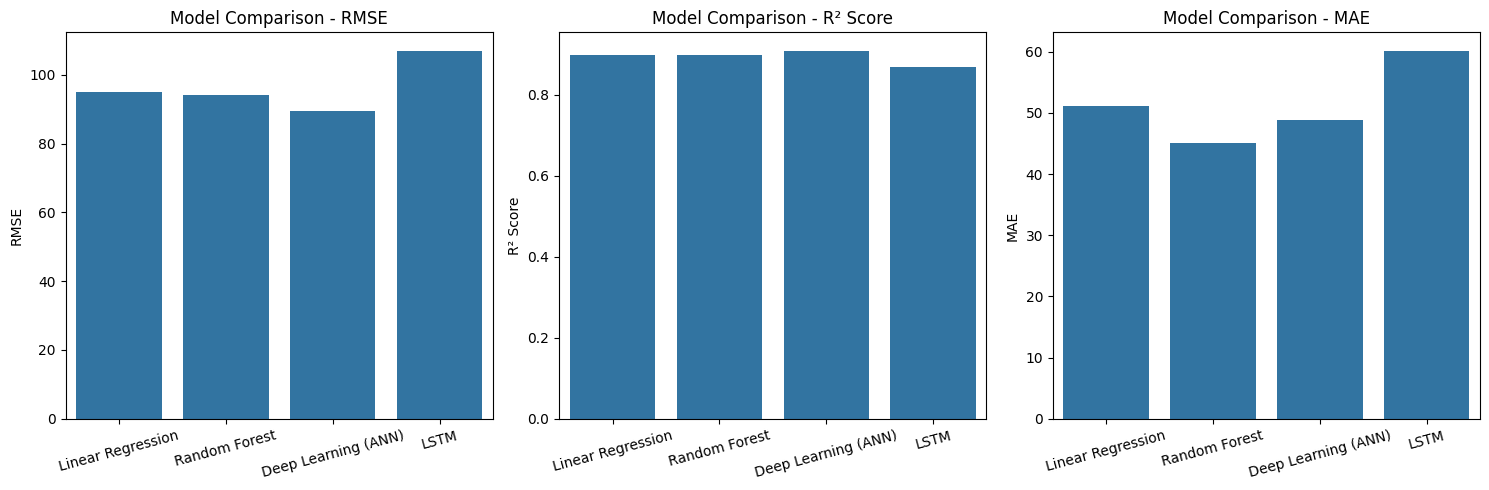

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define metrics for comparison
metrics = ["RMSE", "R² Score", "MAE"]
values = {metric: [evaluation_results[model][i] for model in evaluation_results] for i, metric in enumerate(metrics)}

# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
model_names = list(evaluation_results.keys())

for i, metric in enumerate(metrics):
    sns.barplot(x=model_names, y=values[metric], ax=axes[i])
    axes[i].set_title(f"Model Comparison - {metric}")
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(range(len(model_names)))  # FIXED: Set explicit tick positions
    axes[i].set_xticklabels(model_names, rotation=15)  # FIXED: Properly assign tick labels

plt.tight_layout()
plt.show()


 Get User Input for Prediction

In [41]:
# Get user input dynamically
user_input = [float(input(f"{feature}: ")) for feature in X.columns]

# Predict solar radiation
predicted_values = predict_solar_radiation(user_input)

# Display results
print("Predicted Solar Radiation:")
for model, prediction in predicted_values.items():
    print(f"{model}: {prediction:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\Users\ippil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ippil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Predicted Solar Radiation:
Linear Regression: 719.5770
Random Forest: 794.1900
Deep Learning (ANN): 723.8625
LSTM: 683.2844
